In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random

/Users/baehuijin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# 랜덤 시드 고정
SEED = 2024
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [3]:
# 1. 데이터 로드 및 전처리
data = pd.read_csv('아파트매매지수예측_변수.csv').drop(columns='Unnamed: 0')

data

,아파트매매지수,부동산심리지수,kospi,소비자물가지수,New_COFIX,Outstanding_COFIX,실업률,아파트거래량,지가변동률
0,80.0,122.9,2120.03,88.654,3.42,3.69,4.2,4096,0.067
1,80.2,128.3,2160.09,89.250,3.52,3.73,4.3,4931,0.052
2,80.0,121.7,1887.21,89.164,3.56,3.74,4.4,4868,0.049
3,79.4,109.2,1683.94,89.079,3.54,3.76,4.0,4701,0.043
4,78.6,100.4,1891.22,89.079,3.59,3.78,4.0,4568,0.037
...,...,...,...,...,...,...,...,...,...
153,160.0,110.0,2766.24,113.370,3.71,3.95,3.6,4840,0.238
154,161.4,113.0,2679.04,113.420,3.70,3.96,3.6,5182,0.246
155,164.1,120.1,2657.81,113.170,3.77,3.96,3.3,6150,0.269
156,167.6,123.5,2792.96,113.460,3.80,3.95,2.6,9518,0.282


In [4]:
data['Target'] = (data['아파트매매지수'].diff() > 0).astype(int)  # 1 if increase, 0 if decrease

data.drop(0, inplace=True)

data

,아파트매매지수,부동산심리지수,kospi,소비자물가지수,New_COFIX,Outstanding_COFIX,실업률,아파트거래량,지가변동률,Target
1,80.2,128.3,2160.09,89.250,3.52,3.73,4.3,4931,0.052,1
2,80.0,121.7,1887.21,89.164,3.56,3.74,4.4,4868,0.049,0
3,79.4,109.2,1683.94,89.079,3.54,3.76,4.0,4701,0.043,0
4,78.6,100.4,1891.22,89.079,3.59,3.78,4.0,4568,0.037,0
5,77.7,99.0,1911.50,89.335,3.62,3.81,4.3,6207,0.038,0
...,...,...,...,...,...,...,...,...,...,...
153,160.0,110.0,2766.24,113.370,3.71,3.95,3.6,4840,0.238,1
154,161.4,113.0,2679.04,113.420,3.70,3.96,3.6,5182,0.246,1
155,164.1,120.1,2657.81,113.170,3.77,3.96,3.3,6150,0.269,1
156,167.6,123.5,2792.96,113.460,3.80,3.95,2.6,9518,0.282,1


In [5]:
# Selecting relevant features and target
features = data.drop(columns=['Target', '아파트매매지수'])
target = data['Target']

In [6]:
# Scaling the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

In [13]:
# Preparing the time series data for LSTM
def create_sequences(features, target, time_steps=12):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i+time_steps])
        y.append(target[i+time_steps])
    return np.array(X), np.array(y)

In [14]:
  # Using the past 12 months to predict the next
X, y = create_sequences(scaled_features, target.values)



In [15]:
X.shape,y.shape

((145, 12, 8), (145,))

In [117]:
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


In [118]:
# Splitting the data into train and test sets based on time (no shuffling)
train_size = int(len(X) * 0.8)  # Use 80% for training
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [119]:
# Step 2: Define the LSTM model
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(8, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

/Users/baehuijin/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [120]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [121]:
# Step 3: Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1, class_weight=class_weights_dict)



Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.3847 - loss: 0.7302 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3309 - loss: 0.7151 - val_accuracy: 0.7727 - val_loss: 0.6794
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5675 - loss: 0.7132 - val_accuracy: 0.7727 - val_loss: 0.6617
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6761 - loss: 0.7145 - val_accuracy: 0.7727 - val_loss: 0.6489
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6999 - loss: 0.7161 - val_accuracy: 0.7727 - val_loss: 0.6344
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7474 - loss: 0.7294 - val_accuracy: 0.7727 - val_loss: 0.6261
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7649 - loss: 0.7307 - val_accuracy: 0.7727 - val_loss: 0.6307
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7745 - loss: 0.7170 - val_accuracy: 0.7727 - val_loss:

In [122]:
# Step 4: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {accuracy:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6667 - loss: 0.6229
Test Accuracy: 0.67


In [134]:
y_pred_prob = model.predict(X_test)
y_pred_prob

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


array([[0.60710865],
       [0.6066611 ],
       [0.6062372 ],
       [0.60559034],
       [0.6049711 ],
       [0.6045195 ],
       [0.6041889 ],
       [0.60398334],
       [0.603867  ],
       [0.60364956],
       [0.6032587 ],
       [0.6025825 ],
       [0.6015541 ],
       [0.6002521 ],
       [0.5987898 ],
       [0.5969661 ],
       [0.5948833 ],
       [0.5927058 ],
       [0.5906749 ],
       [0.5892362 ],
       [0.5910041 ],
       [0.60057336],
       [0.6386304 ],
       [0.6801288 ],
       [0.6932098 ],
       [0.7032297 ],
       [0.7001121 ]], dtype=float32)

In [135]:
thr = 0.6

y_pred_prob[y_pred_prob < thr] = 0
y_pred_prob[y_pred_prob >= thr] = 1

Text(50.722222222222214, 0.5, 'True Label')

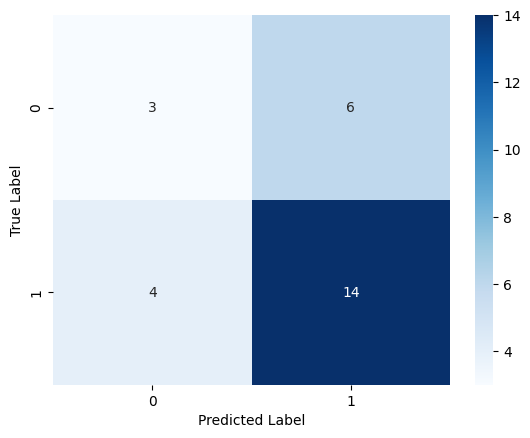

In [136]:
cf = confusion_matrix(y_test, y_pred_prob)

sns.heatmap(cf, annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [137]:
from sklearn.metrics import f1_score, accuracy_score

In [138]:
print("F1_Score : ", f1_score(y_test, y_pred_prob))

print("Accuracy : ", accuracy_score(y_test, y_pred_prob))

F1_Score :  0.7368421052631579
Accuracy :  0.6296296296296297
